**NOTE**

I have tried for many hours now to export this as a pdf and it keeps failing.

# Setup

In [10]:
%reset -f

In [421]:
# Standard Imports
import os
from collections.abc import Iterable
import numpy as np
from datetime import datetime
import itertools as it
import pandas as pd
import pandas_datareader as pdr
from pandas import IndexSlice
from dateutil.relativedelta import relativedelta
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tabulate import tabulate
import utils
%matplotlib inline

In [422]:
# Third Party Imports - CSV files stored locally so do not need this afterwards
from iexfinance import stocks
from iexfinance.refdata import get_symbols

In [423]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [424]:
# Globals
idx = IndexSlice
RANDOM_SEED = utils.RANDOM_SEED
SKLEARN_RANDOM_SEED = utils.SKLEARN_RANDOM_SEED
PRICE = utils.PRICE
RETURN = utils.RETURN
TARGET_COL = utils.TARGET_COL

DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(DATA_DIR, exist_ok=True)
IMAGES_DIR = os.path.join(os.getcwd(), "images")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [425]:
def get_symbol_list():
    _avail_symbols = get_symbols()

    # Convert to dataframe and set index to "symbol" / ticker
    df_symbols = pd.DataFrame(_avail_symbols).set_index("symbol")
    
    df_companies = df_symbols[
    df_symbols.name.str.contains("Momenta Pharmaceuticals") |
    df_symbols.name.str.contains("Zoetis")
    ]

    symbol_list = df_companies.index.to_list()
    
    return symbol_list

The following sections can be skipped and you can read in the data from \
the [completed feature engineering dataset here](#read_completed_dataset).


# Data Retrivial

## Obtain Ticker(s) and Fama-French Dataset Name

Retrieve Symbol(s)

In [18]:
symbol_list = get_symbol_list()
symbol_list

['MNTA', 'ZTS']

Fama-French Availale Data

In [19]:
ff_avail_data = pdr.famafrench.get_available_datasets()

In [20]:
list((s for s in ff_avail_data if "f-f" in s.lower()))

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'F-F_Momentum_Factor',
 'F-F_Momentum_Factor_daily',
 'F-F_ST_Reversal_Factor',
 'F-F_ST_Reversal_Factor_daily',
 'F-F_LT_Reversal_Factor',
 'F-F_LT_Reversal_Factor_daily']

## Download data
+ **force_api_call**: if True does not read local csv file and uses IEX api call to retrieve data: Data stored in /data/symbol_raw_data.csv
+ **ff_dataset_name**: Fama French dataset to download using pandas_datareader.

In [21]:
# User Settings
force_api_call = False
ff_dataset_name = "F-F_Research_Data_5_Factors_2x3_daily"

end = datetime(2020, 5, 19)
n_years = 5

start = end - relativedelta(end, years=n_years)

end, start

(datetime.datetime(2020, 5, 19, 0, 0), datetime.datetime(2015, 5, 19, 0, 0))

### Retrieve Fama-French Data

In [22]:
#Loading Factor Data
_tmp_local_fpath = os.path.join(DATA_DIR, f"{ff_dataset_name}_raw_data.csv".lower())

if not os.path.exists(_tmp_local_fpath) or force_api_call:
    
    _tmp_df_ff = pdr.data.DataReader(ff_dataset_name, start=start, end=end, data_source="famafrench")[0].iloc[:, idx[:5]]
    _tmp_df_ff.index = pd.to_datetime(_tmp_df_ff.index, format="%Y%m%d", utc=False)
                                     
    print(f"\nLocal csv filepath to write {ff_dataset_name} raw data to,\n\n>> {_tmp_local_fpath}\n")
    _tmp_df_ff.to_csv(_tmp_local_fpath)
    
else:
    print(f"Reading in data from,\n\n>> {_tmp_local_fpath}\n")
    _tmp_df_ff = pd.read_csv(_tmp_local_fpath, index_col=0)

# Store columns from Fama-French Dataset
cols_ff = list(_tmp_df_ff.columns)

with pd.option_context("max_rows", 5):
    display(_tmp_df_ff)

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\f-f_research_data_5_factors_2x3_daily_raw_data.csv



Mkt-RF   SMB   HML   RMW   CMA
Date                                      
2015-05-19   -0.09 -0.07  0.23 -0.09 -0.04
2015-05-20   -0.05  0.19 -0.13 -0.13  0.06
...            ...   ...   ...   ...   ...
2020-03-30    3.16 -0.82 -2.18 -0.17  0.18
2020-03-31   -1.44  1.51 -0.43  0.39 -0.13

[1226 rows x 5 columns]

### Retrieve Asset(s) Data

Gather raw (uncleaned and augmented data) for the assets within the `symbol_list` and store in a dict.
```python
df_raw_dict = {
    symbol : DataFrame
}
```

In [23]:
# Dict to hold dataframe for each symbol
df_raw_dict = dict()
# df_raw_list = []  # TODO: is this still required?

# This is the column name for the closing price

for symbol in symbol_list:
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_raw_data.csv".lower())
    
    # keyword arguments called to api call
    kwargs = {
        "symbols":symbol, 
        "output_format":"pandas",
        "end":end,
        "start":start
    }
    
    # Retrieve data
    if not os.path.exists(local_fpath) or force_api_call:
        
        print(f"Using api call with kwargs: {kwargs}")
        _tmp_df = stocks.get_historical_data(**kwargs)[[PRICE]]
        
        print(f"\nLocal csv filepath to write raw data to,\n\n>> {local_fpath}\n")
        _tmp_df.to_csv(local_fpath)
    
    else:
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        _tmp_df = pd.read_csv(local_fpath, index_col=0)
    
    # Join Fama-French Data
    _tmp_df = _tmp_df.join(_tmp_df_ff)
    
    # df_raw_list.append(df_tmp)    # TODO: is this still required? or prefer using dict going foward?
    df_raw_dict[symbol] = _tmp_df

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_raw_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_raw_data.csv



### Remove NaN values

In [25]:
df_clean_dict = dict()

with pd.option_context("max_rows", 5):
    for symbol, df in df_raw_dict.items():
        
        df_clean_dict[symbol] = df.fillna(axis=0, method="ffill")
        
        print("-"*50, "\n", symbol)
        
        display(df_clean_dict[symbol])
        
    print("-"*50)

-------------------------------------------------- 
 MNTA


close  Mkt-RF   SMB   HML   RMW   CMA
date                                             
2015-05-20  19.29   -0.05  0.19 -0.13 -0.13  0.06
2015-05-21  19.31    0.23 -0.30 -0.02  0.07 -0.15
...           ...     ...   ...   ...   ...   ...
2020-05-18  31.42   -1.44  1.51 -0.43  0.39 -0.13
2020-05-19  30.39   -1.44  1.51 -0.43  0.39 -0.13

[1259 rows x 6 columns]

-------------------------------------------------- 
 ZTS


close  Mkt-RF   SMB   HML   RMW   CMA
date                                              
2015-05-20   47.28   -0.05  0.19 -0.13 -0.13  0.06
2015-05-21   47.80    0.23 -0.30 -0.02  0.07 -0.15
...            ...     ...   ...   ...   ...   ...
2020-05-18  131.42   -1.44  1.51 -0.43  0.39 -0.13
2020-05-19  134.34   -1.44  1.51 -0.43  0.39 -0.13

[1259 rows x 6 columns]

--------------------------------------------------


Write / Load Cleaned Data

## Save Clean Data to CSV

In [26]:
for symbol, df in df_clean_dict.items():
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
    print(f"\nLocal csv filepath to write cleaned data to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write cleaned data to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_clean_data.csv


Local csv filepath to write cleaned data to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_clean_data.csv



## Read Clean Data from CSV

In [91]:
_df_tmp_dict = dict()

symbol_list = get_symbol_list()

try:
    
    for symbol in symbol_list:
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_clean_dict = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_clean_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_clean_data.csv

Data succesfully read in.



In [28]:
df_clean_dict[symbol_list[0]][PRICE]

date
2015-05-20    19.29
2015-05-21    19.31
2015-05-22    19.88
2015-05-26    19.39
2015-05-27    19.61
              ...  
2020-05-13    28.98
2020-05-14    29.88
2020-05-15    31.09
2020-05-18    31.42
2020-05-19    30.39
Name: close, Length: 1259, dtype: float64

# Feature Engineering

Add returned data for 1D - N_Days (end inclusive) and store *copied* dataframe in new dict.
```python
df_aug_dict = {
    symbol : DataFrame 
}
```
with columns,
<br><br>
["Mkt-RF", "SMB","HML", "RMW", "CMA, "return", "return_sign", "ret_2", "ret_2_sign",..., "ret_N", "ret_N_sign", "mom_1", ..., "mom_N"]
<br><br>
**WARNING**: for np.sign(X) if x == 0, then sign == 0. Thus 3 possible returns from np.sign are [-1, if x<0, 0 if x==0, 1 if x>0]. Not a binomial output.

In [92]:
aug_data = utils.feature_engineering(df_clean_dict, use_mom_ma=True)

Rather than using the pure SMA and EMA values. I have used 1 day momentum of them via the `use_mom_ma=True` parameter. \
I am only interested in how these change anyway and this should allow the model to be used on other well correlated stocks. \
If you keep the absoulte values then when using `StandardScalar` it does not work well on other assets with different \
absolute values of SMA and EWMA

In [93]:
df_aug_dict = aug_data["df_dict"]

In [94]:
np.isnan(df_aug_dict[symbol_list[0]]).apply("sum", axis=0).sum()

0

There should be no NaN values in above out. If there is then remove "sum" and identify column with NaN values.

In [ ]:
df_aug_dict[symbol_list[0]].describe()

In [ ]:
df_aug_dict[symbol_list[0]].head(5).T

Identify how well correlated the returns/return sign of the stocks are too each other

In [97]:
series_list = []

for symbol, df in df_aug_dict.items():
    series = df[RETURN].copy()
    series.name = symbol
    
    series_list.append(series)
    
_tmp_df = pd.DataFrame(series_list).T
returns_corr = _tmp_df.corr()
returns_corr[returns_corr == 1] = 0
returns_corr

MNTA       ZTS
MNTA  0.000000  0.341514
ZTS   0.341514  0.000000

In [98]:
series_list = []

for symbol, df in df_aug_dict.items():
    series = df[TARGET_COL].copy()
    series.name = symbol
    
    series_list.append(series)
    
_tmp_df = pd.DataFrame(series_list).T
sign_corr = _tmp_df.corr()
sign_corr[sign_corr == 1] = 0
sign_corr

MNTA       ZTS
MNTA  0.000000  0.272627
ZTS   0.272627  0.000000

Do some further analysis of augmented features, especially target column "return_sign"

In [99]:
# Use a copied dataframe to do some further investigation with.
_tmp_df = df_aug_dict[symbol_list[0]].copy()

vc = lambda col: col.value_counts()
_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False)

return_sign
 1          612
 0           41
-1          585

Replace signs of 0 with NaN and use forward fill to convert this to a binomial classification task

In [100]:
_tmp_df.loc[:, TARGET_COL] = (_tmp_df.loc[:, TARGET_COL]  # Select all columns that hold a return sign
                                .replace(0, np.nan)    # replace 0 with NaN value
                                .fillna(axis=0, method="ffill") # Use forward fill on NaN values
                               ).astype(np.int)

_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False)

return_sign
 1          629
-1          609

Implement above steps on dataframes in df_aug_dict

In [101]:
vc = lambda col: col.value_counts()

# Keep reference to a dataframe in dict
_tmp_df = df_aug_dict[symbol_list[1]]

print("Before")
display(_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False))

for symbol, df in df_aug_dict.items():
    df.loc[:, TARGET_COL] = (df[[TARGET_COL]]  # Select all columns that hold a return sign
                                .replace(0, np.nan)    # replace 0 with NaN value
                                .fillna(axis=0, method="ffill") # Use forward fill on NaN values
                               ).astype(np.int)

print("After")
display(_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False))

Before


return_sign
 1          659
 0           14
-1          565

After


return_sign
 1          666
-1          572

In [102]:
np.isnan(_tmp_df).apply("sum", axis=0).sum()

0

## Save Augmented Features Dataset to CSV

In [103]:
for symbol, df in df_aug_dict.items():
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_aug_data.csv".lower())
    
    print(f"\nLocal csv filepath to write augmented features dataset to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write augmented features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_aug_data.csv


Local csv filepath to write augmented features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_aug_data.csv



## Read Augmented Features Dataset from CSV
Ensure `symbol_list` has been defined

In [437]:
_df_tmp_dict = dict()

try:
    
    for symbol in symbol_list:
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_aug_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_aug_dict = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_aug_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_aug_data.csv

Data succesfully read in.



In [ ]:
df_aug_dict[symbol_list[0]].info()

## Time shift data
The data we have so far is "todays values" for each date and "known return for today + return sign" \
Hence we need to shift columns such that we have todays data and predicted tomorrow return sign. \
hence shift "return_sign" back by 1 day

In [439]:
# Temporarily reverse colum direction to view return sign
with pd.option_context("max_rows", 10, "max_columns", 10):
    display(df_aug_dict[symbol_list[0]].head(6)[df_aug_dict[symbol_list[0]].columns[::-1]])

return_sign    STD21D    STD14D     STD7D    EWM21D  ...   RMW  \
date                                                             ...         
2015-06-19           -1  0.016255  0.031240  0.046574  0.177947  ...  0.07   
2015-06-22            1  0.023466  0.042984  0.082212  0.208668  ... -0.16   
2015-06-23            1  0.045402  0.046225 -0.065269  0.206445  ... -0.08   
2015-06-24           -1 -0.085641 -0.070141 -0.092341  0.086522  ...  0.18   
2015-06-25           -1 -0.114769 -0.039785 -0.077105  0.023556  ...  0.18   
2015-06-26            1 -0.169387 -0.016080 -0.113708  0.083045  ...  0.32   

             HML   SMB  Mkt-RF  close  
date                                   
2015-06-19 -0.20  0.52   -0.43  23.78  
2015-06-22 -0.06  0.09    0.63  24.28  
2015-06-23  0.27  0.24    0.12  24.49  
2015-06-24  0.13 -0.14   -0.79  23.52  
2015-06-25 -0.20  0.33   -0.25  22.98  
2015-06-26  0.45 -0.19   -0.06  23.61  

[6 rows x 49 columns]

In [441]:
df_completed_dict = dict()

for symbol, df in df_aug_dict.items():
    df_copy = df.copy()
    
    
    df_copy[TARGET_COL] = df_copy[TARGET_COL].shift(-1)
    
    df_completed_dict[symbol] = df_copy.dropna()

In [442]:
with pd.option_context("max_rows", 10, "max_columns", 10):
    display(df_completed_dict[symbol_list[0]].head(5)[df_completed_dict[symbol_list[0]].columns[::-1]])

return_sign    STD21D    STD14D     STD7D    EWM21D  ...   RMW  \
date                                                             ...         
2015-06-19          1.0  0.016255  0.031240  0.046574  0.177947  ...  0.07   
2015-06-22          1.0  0.023466  0.042984  0.082212  0.208668  ... -0.16   
2015-06-23         -1.0  0.045402  0.046225 -0.065269  0.206445  ... -0.08   
2015-06-24         -1.0 -0.085641 -0.070141 -0.092341  0.086522  ...  0.18   
2015-06-25          1.0 -0.114769 -0.039785 -0.077105  0.023556  ...  0.18   

             HML   SMB  Mkt-RF  close  
date                                   
2015-06-19 -0.20  0.52   -0.43  23.78  
2015-06-22 -0.06  0.09    0.63  24.28  
2015-06-23  0.27  0.24    0.12  24.49  
2015-06-24  0.13 -0.14   -0.79  23.52  
2015-06-25 -0.20  0.33   -0.25  22.98  

[5 rows x 49 columns]

In [ ]:
df_completed_dict[symbol_list[0]].info()

Thus each row should now ask the question \
"given todays know data what is tomorrows predicted direction"

# Completed Dataset

you can skip directly to reading in the data after running the **Setup** section of this notebook

**Save Completed Features Dataset to CSV**

In [111]:
for symbol, df in df_completed_dict.items():
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_comp_data.csv".lower())
    
    print(f"\nLocal csv filepath to write completed features dataset to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write completed features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_comp_data.csv


Local csv filepath to write completed features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_comp_data.csv



**Read Completed Features Dataset from CSV**
<a id='read_completed_dataset'></a>

you can skip all procedding steps and use this directly

In [112]:
# Clean variables in memory using regex
%reset_selective -f "df[A-Za-a0-9]*"

In [426]:
_df_tmp_dict = dict()

symbol_list = get_symbol_list()

try:
    
    for i, symbol in enumerate(symbol_list):
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_comp_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_work = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_comp_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_comp_data.csv

Data succesfully read in.



In [114]:
# Remove _tmp variables in memory using regex
%reset_selective -f "_tmp[A-Za-z]*"

In [443]:
with pd.option_context("max_rows", 10, "max_columns", 10):
    display(df_work[symbol_list[0]].describe())

close       Mkt-RF          SMB          HML          RMW  ...  \
count  1237.000000  1237.000000  1237.000000  1237.000000  1237.000000  ...   
mean     16.497963    -0.013977     0.017292    -0.045707     0.016783  ...   
std       5.621741     1.182341     0.612449     0.621163     0.354127  ...   
min       8.210000   -12.000000    -4.590000    -4.720000    -1.670000  ...   
25%      12.450000    -0.370000    -0.340000    -0.430000    -0.200000  ...   
50%      14.900000     0.040000    -0.030000    -0.080000     0.020000  ...   
75%      18.600000     0.490000     0.330000     0.290000     0.250000  ...   
max      34.300000     9.340000     5.750000     3.080000     1.630000  ...   

            EWM21D        STD7D       STD14D       STD21D  return_sign  
count  1237.000000  1237.000000  1237.000000  1237.000000  1237.000000  
mean      0.007302     0.000801     0.000558    -0.000143     0.016977  
std       0.149039     0.196474     0.137900     0.111553     1.000260  
min      -0.677088    -1.856571    -1.322413    -0.944579    -1.000000  
25%      -0.061727    -0.053155    -0.035197    -0.033087    -1.000000  
50%       0.008104    -0.002224    -0.000072    -0.000679     1.000000  
75%       0.075006     0.055590     0.036023     0.030722     1.000000  
max       0.877092     1.749897     1.240659     0.883733     1.000000  

[8 rows x 49 columns]

# Data Visualisation

## Multi Asset Returns history

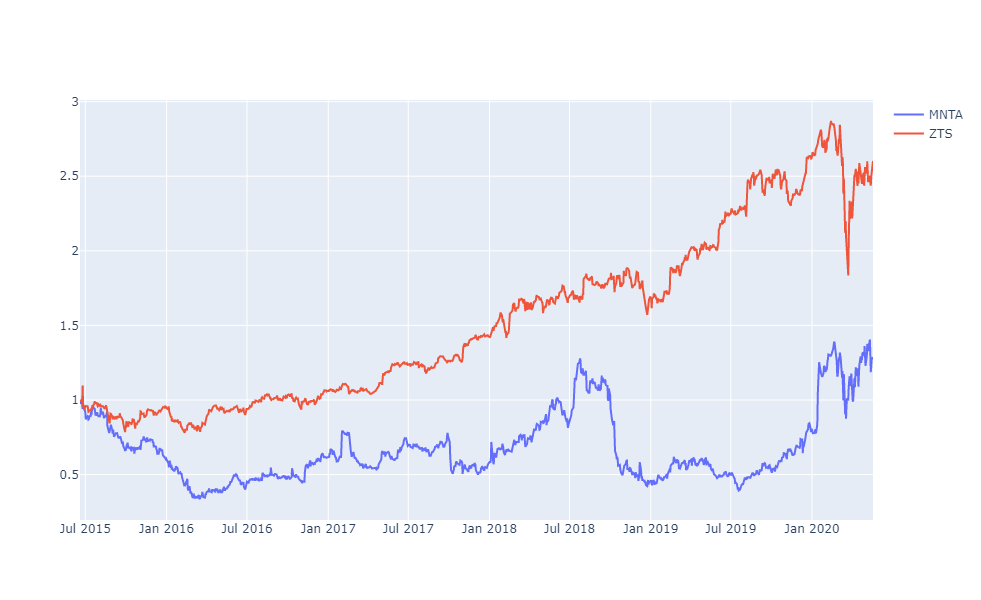

In [427]:
fig = go.Figure(layout=dict(height=600, width=800, showlegend=True))
for symbol, df in df_work.items():
    trace = go.Scatter(
        x=df.index,
        y=df[RETURN].cumsum().apply(np.exp),
        name=symbol
    )

    fig.add_trace(trace)

#fig.write_image(os.path.join(IMAGES_DIR, "returns_history.svg"));
fig.show()

## Single Asset Scatter Matrix

Select a single asset for scatter matrix plotting

In [117]:
df_stock = df_work[symbol_list[0]]

Get indexes for the columns for when we use `df.iloc` later on

In [ ]:
available_columns = df_stock.columns.to_list()
list(zip(it.count(0), available_columns))

In [429]:
target_col_index = available_columns.index(TARGET_COL)
target_col_index

48

In [430]:
selected_cols = [target_col_index] + [available_columns.index(col) for col in ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
selected_cols

[48, 1, 2, 3, 4, 5]

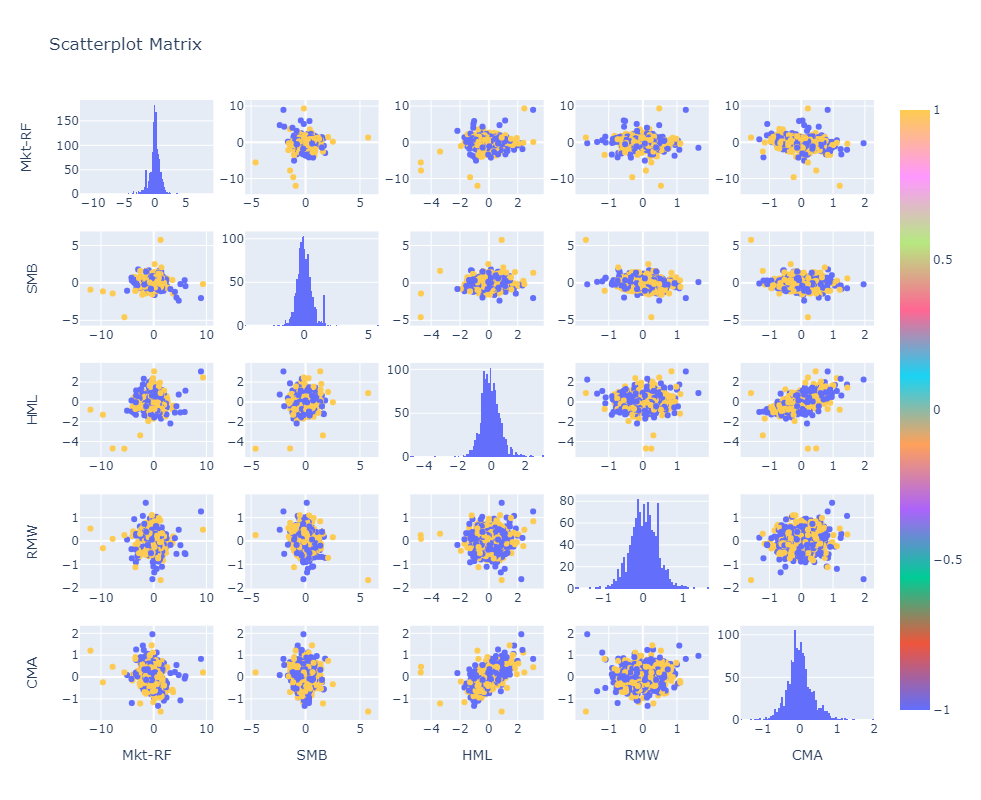

In [435]:
from plotly.figure_factory import create_scatterplotmatrix
fig = create_scatterplotmatrix(df_stock.iloc[:, list(set(selected_cols + [target_col_index]))], diag='histogram', index="return_sign",
                                  height=800, width=800, colormap=px.colors.qualitative.Plotly)

#fig.write_image(os.path.join(IMAGES_DIR, "scatter_matrix1.png"));
#fig.write_image(os.path.join(IMAGES_DIR, "scatter_matrix1.svg"));
fig.show(config={"staticPlot":True})

# Model Preparation Steps

In [433]:
#### Util
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedShuffleSplit, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from scipy import stats

Select stock to operate on

In [122]:
df_stock = df_work[symbol_list[0]]

In [123]:
# We will split the data set into an insample and out of sample dataset
insample = int(df_stock.index.size*0.8)
outsample = df_stock.index.size - insample

df_in = df_stock.iloc[:insample].copy()
df_out = df_stock.iloc[insample:].copy()

# Quick check to confirm ratio's
headers = ["In Sample", "Out Sample"]
tabular_data = [[df_in.size/df_stock.size, df_out.size/df_stock.size]]
table = tabulate(tabular_data=tabular_data, headers=headers)
print(table)

  In Sample    Out Sample
-----------  ------------
   0.799515      0.200485


In [125]:
df_in[TARGET_COL].value_counts()

 1.0    498
-1.0    491
Name: return_sign, dtype: int64

In [152]:
def initial_sample_preparation(df):
    X = df.drop(columns=[PRICE, TARGET_COL, f"{RETURN}_pct"]).copy()
    Y = df[TARGET_COL].copy().astype("int")
    Y[Y==-1] = 0
    return (X, Y)

Split Insample dataframe into features and labels

In [153]:
X, Y = initial_sample_preparation(df_in)

In [128]:
Y.value_counts()

1    498
0    491
Name: return_sign, dtype: int64

**Split into train, dev/test**

The test set acts more as a validation/dev set with the out of sample dataframe being used later as main test set. \
Hence the test_size will be set to a value lower than 10%

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=SKLEARN_RANDOM_SEED)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((890, 46), (890,), (99, 46), (99,))

**Scale Input Features**

make sure to use this on out of sample dataset later

In [155]:
scalar = StandardScaler()

X_train_scaled = scalar.fit_transform(X_train)
X_dev_scaled = scalar.transform(X_dev)

**Prepate out of sample for use later on**

In [156]:
X_out, Y_out = initial_sample_preparation(df_out)

In [157]:
Y_out.value_counts()

1    131
0    117
Name: return_sign, dtype: int64

In [159]:
X_test_scaled = scalar.transform(X_out)
y_test = Y_out.values.ravel()

# Classifier A.1 Logistic Regression

For one training example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
<br><br>
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
<br><br>
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$
where sigmoid is defined as,

$$ sigmoid(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}} $$
The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$


**L2 Regularization - Ridge**

\begin{equation}
    w = \left(w_1, w_2, ..., w_{n_x}\right)
\end{equation}
<br>
\begin{equation}
    J(\theta) = L(\theta) + \alpha \frac{1}{2} \sum_{i=1}^{n_{x}} w_{i}^2
\end{equation}
<br>
the regularized term at the end is added to the cost function. This is the euclidean norm of the weights vector. \
This regularization has the effect that the model tries not only to minimise the loss function, $L(\theta)$, but \
it also tries to keep the model weights as small ass possible. The regularization hyperparameter $\alpha$ determines \
how much regularization is applied. 
+ A high alpha increase regularization and hence model reduces weights even more.
+ An alpha close to zero will lead to little or no regularization.
Regularization is used to reduce model complexity to avoid overfitting, hence allow better generalization. \
Note that the bias term is not regularized. Ridge regression is senstive to scale of input features. \
If scale between features are vastly different then so will the scales of the weights between features. \
This results in gradient descent sending smaller weights to zero much faster than larger weights. \
To avoid this it is important that features are scalled before model fitting.

**L1 Regularization - Lasso**
<br>
\begin{equation}
    J(\theta) = L(\theta) + \alpha \sum_{i=1}^{n_{x}} |w_{i}|
\end{equation}
<br>
regularized term is l1 norm, manhattan norm. 

**L1 vs L2 Regularization**
L2 regularization tends to send many feature weights to small values, however l1 regularization will tend to send the less \
important features to zero and hence can be considered a form of automatic feature selection.

**Logistic Regression Regularization**
The hyperparameter used for regularization in Logistic Regression in sklearn is "C" and it is the inverse of $\alpha$
+ Lower values of C mean higher regularization and hence reduced model complexity
+ higher values of C mean lower regularization and hence increased model complexity

<br>

Solver selection
+ ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
+ ‘liblinear’ and ‘saga’ also handle L1 penalty
+ ‘saga’ also supports ‘elasticnet’ penalty

it seems the 'saga' solver is the only one that supports both L1 and L2 and hence elasticnet


## A1 a) - Comparison of L1 and L2 coefficients

Apply L2 regularization

In [160]:
log_l2_clf = LogisticRegression(C=1, penalty="elasticnet", solver="saga", l1_ratio=0,
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
log_l2_clf.fit(X_train_scaled, y_train.ravel());

Apply L1 regularization

In [161]:
log_l1_clf = LogisticRegression(C=1, penalty="elasticnet", solver="saga", l1_ratio=1,
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
log_l1_clf.fit(X_train_scaled, y_train.ravel());

Analyse L1 vs L2 regularization effect on coefficients

In [162]:
log_l2_clf.coef_.shape

(1, 46)

In [163]:
l1_coeff = pd.Series({"$w_{%d}$"%i: log_l1_clf.coef_[0][i] for i in range(X_train_scaled.shape[1])}, name="l1")
l2_coeff = pd.Series({"$w_{%d}$"%i: log_l2_clf.coef_[0][i] for i in range(X_train_scaled.shape[1])}, name="l2")
df_coeff = pd.DataFrame([l1_coeff, l2_coeff])
(df_coeff.T == 0).sum()

l1    16
l2     0
dtype: int64

In [164]:
(df_coeff.T == 0).sum() / df_coeff.columns.size

l1    0.347826
l2    0.000000
dtype: float64

L1 has sent set ~ 40% of the cofficients to a value of zero.

## A1 b) Stratified Kfold Cross-Validation

Class split of training set

In [166]:
pd.Series(y_train.ravel()).value_counts() / y_train.size

0    0.503371
1    0.496629
dtype: float64

In [167]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=SKLEARN_RANDOM_SEED)

i = 1

# Note that we give y_train so that split knows the classes to do stratification on.
for train_index, val_index in split.split(X_train_scaled, y_train):
    
    # Get stratified train and test sets
    X_train_strat = X_train_scaled[train_index]
    X_val_strat = X_train_scaled[val_index]
    
    # Get stratified train and test labels
    y_train_strat = y_train[train_index]
    y_val_strat = y_train[val_index]
    
    print("\nSplit number %d" %i)
    print(pd.Series(y_train_strat.ravel()).value_counts()/ y_train_strat.size)
    print(pd.Series(y_val_strat.ravel()).value_counts()/ y_val_strat.size)
    
    i += 1


Split number 1
0    0.502809
1    0.497191
dtype: float64
0    0.505618
1    0.494382
dtype: float64

Split number 2
0    0.502809
1    0.497191
dtype: float64
0    0.505618
1    0.494382
dtype: float64


Stratified split keeps similar proporations of classes within each cross validation split. \
We can u se this for training multiple classifiers and use the average score

In [206]:
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SKLEARN_RANDOM_SEED)

l2_clf = LogisticRegression(C=0.59, penalty="l2", solver="lbfgs",
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
scores = []

# Note that we give y_train so that split knows the classes to do stratification on.
for train_index, val_index in split.split(X_train_scaled, y_train):
    
    # each fold is trained on a separate classifier instances
    clf = clone(l2_clf)
    
    # Get stratified train and test sets
    X_train_strat = X_train_scaled[train_index]
    X_val_strat = X_train_scaled[val_index]
    
    # Get stratified train and test labels
    y_train_strat = y_train[train_index]
    y_val_strat = y_train[val_index]
    
    clf.fit(X_train_strat, y_train_strat.ravel())
    
    y_pred = clf.predict(X_val_strat)
    
    acc = accuracy_score(y_val_strat, y_pred)
    
    scores.append(acc)

np.mean(scores)

0.48707865168539327

In [207]:
cv_scores = cross_val_score(l2_clf, X_train_scaled, y_train, cv=10, scoring="accuracy", n_jobs=-1)
np.mean(cv_scores)

0.47415730337078654

hence we see that using stratified cross validation and `cross_val_score` produce similar results

## B.2) Optimise hyperparameters
using Random Cross Validation we can search for optimal hyperparameters to use. \
Due to varying senstivity of C it makes more sense to sample uniformly across a logmarithmic distributions. \
Elastic net is used so that we can essentially switch from L1 to L2 regularization when using random search.

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [193]:
param_distribution = {
    "C": stats.loguniform(10**-5, 10*5),
    "l1_ratio": stats.randint(0, 1)   # 0 = L2,  1 = L1
}

rscv_log = RandomizedSearchCV(
    estimator=LogisticRegression(penalty="elasticnet", solver="saga",max_iter=10000, random_state=SKLEARN_RANDOM_SEED),
    param_distributions=param_distribution,
    scoring="accuracy",
    n_iter=5000,
    cv=5,
    n_jobs=-1,
    refit=True, # model with best score is re-trained on entire training set
    verbose=1,
    random_state=SKLEARN_RANDOM_SEED)

In [ ]:
rscv_log.fit(X_train_scaled, y_train.ravel());

In [197]:
print(f"""
Model with highest accuracy of {rscv_log.best_score_:.5f} obtained with parameters
C = {rscv_log.best_params_["C"]:.5f}\t | \t l1_ratio = {rscv_log.best_params_["l1_ratio"]}
""")


Model with highest accuracy of 0.50674 obtained with parameters
C = 0.59980	 | 	 l1_ratio = 0



In [198]:
utils.compare_dummy_clf(rscv_log.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.50674, performs BETTER than a Dummy classifier with a score of 0.5


In [199]:
y_pred = rscv_log.best_estimator_.predict(X_dev)
round(accuracy_score(y_dev, y_pred), 5)

0.54545

The best logistic classifier does well on the dev set

# Classifier A.2 SVM

a) Hard Margin linear SVM classifier objective function
---
$$
\displaystyle{\min_{w, b} \frac{1}{2}w^Tw}
$$
subject to,
$$
t^{(i)}\left( w^Tx^{(i)} + b\right) \ge 1 \qquad \text{for i}=1,2,\cdots,m
$$

where $t^{(i)}$ is,
+ -ve for negative class $(y^{(i)} = 0)$ to give a decision function that is less than -1
+ +ve for postive class $(y^{(i)} = 1)$ to give a decision function that is greater than 1

The region between -1 to 1 is the *street/margin* and areas in feature space where the decision function is equal to zero \
define the decision boundary.

the smaller the weight vector **w** the larger the margin. The constraint applied is used to apply a hard margin that requires,
+ All instances must be off the street/margin
+ All instance must be on their right side of the street/margin

These constraints make the hard margin very senstive to outliers. To allow for some margin violation we can adjust the constraint and objective function.

Soft Margin linear SVM classifier objective function
---

A slack variable is introduced for each training instances $ \zeta^{(i)} \ge 0$. $ \zeta^{(i)}$ tells us how much the ith instance is able to \
violate the margin. However this introduces conflicting objectives,
+ minimize $ \zeta^{(i)}$ to reduce margin violations
+ minimize $\frac{1}{2}w^Tw$ to increase margin

A hyperparameter *C* is introudced that controls the relative trade-off between these two objetives.

$$
\displaystyle{\min_{w, b, \zeta} \frac{1}{2}w^Tw} + C \sum_{i=1}^m \zeta^{(i)}
$$

subject to,

$$
t^{(i)}\left( w^Tx^{(i)} + b\right) \ge 1 - \zeta^{(i)} \qquad \text{and} \quad \zeta^{(i)} \ge 0 \qquad \text{for i}=1,2,\cdots,m
$$

A large value of C will result in the optimisation algorithm reducing the slack variables $\zeta^{(i)}$ toward zero \
and hence towards a hard margin classifier. A low value of C will have the opposite effect and behaves as a soft margin classifier. \
Softer margins generalize better hence you can view the C as being a regularization hyperparameter.
<br><br><br>
The above constrained optimisation problem presented above is the "primal" problem and can be converted into an unconstrained optimsation problem \
called the "dual problem". The dual problem can essentially be solved in a manner from Module 2 that used Lagrange Optimisation and it also allows \
for the use of the "kernel trick".

## b) Plot decision boundary

There are two many features to create a proper 2D plot, however I will demonstrate here how to go about it \
via using only the required 2 features to train the model and predict a grid showing decision boundary. \
I will also plot out the location/instances that act as **support vectors** for the model.

In [233]:
from sklearn.svm import SVC

svm_clf = SVC(C=12, gamma=0.04, kernel="rbf", tol=1e-4, random_state=SKLEARN_RANDOM_SEED, probability=True)

In [234]:
idx1 = available_columns.index("MOM1D_t-1")
idx2 = available_columns.index(f"{RETURN}_t-1")

In [235]:
X_reduced = X_train_scaled[:, [idx1, idx2]]
svm_clf.fit(X_reduced, y_train.ravel())

SVC(C=12, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.04, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.0001,
    verbose=False)

Accuracy will be low for this since we are only using two features, Momentum 1D and Return t-1

In [236]:
y_pred = svm_clf.predict(X_reduced)
accuracy_score(y_train.ravel(), y_pred)

0.5280898876404494

In [237]:
# set bound as a % of average of ranges for x and y axis (using 2 features)
bound = 0.1*np.average(np.ptp(X_reduced, axis=0))

# set step size as a % of the average of ranges for x and y (using 2 features)
step = 0.005*np.average(np.ptp(X_reduced, axis=0)) # defines resolution of mesh grid

x_min = X_reduced[:,0].min() - bound
x_max = X_reduced[:,0].max() + bound
y_min = X_reduced[:,1].min() - bound 
y_max = X_reduced[:,1].max() + bound

x_min, x_max, y_min, y_max

(-5.593460608087135, 7.942985489730918, -5.329198222015705, 7.529882038606974)

In [238]:
# The mesh contains the values of each feature
x1_grid, x2_grid = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

x1_grid.shape, x2_grid.shape

((234, 247), (234, 247))

Stack Mesh Horizontally and pass it into trained model.

In [239]:
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# quick check that number of samples is correct
x_grid.shape, x1_grid.shape[0] * x1_grid.shape[1]

((57798, 2), 57798)

In [240]:
y_scores = svm_clf.decision_function(x_grid).reshape(x1_grid.shape)

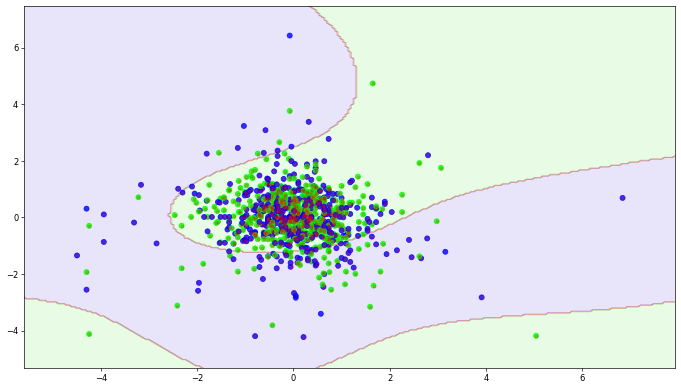

In [241]:
threshold = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), dpi=60)

s = [20*4**n for n in range(svm_clf.support_vectors_.shape[0])]

# Plot contour showing decision boundaries
ax.contourf(x1_grid, x2_grid, y_scores>threshold, cmap=plt.cm.brg, alpha=0.1)

# Plot actual data
ax.scatter(x=X_reduced[:, 0], y=X_reduced[:, 1], c=y_train.ravel(), cmap=plt.cm.brg, alpha=0.8)

# Plot support vectors
_ = ax.scatter(x=svm_clf.support_vectors_[:, 0], y=svm_clf.support_vectors_[:, 1], s=12, color="red", alpha=0.2)

An alternative is to use PCA to reduces dimensions down to 2 and plot the decision boundaries that way.

## B.2) Optimise hyperparameters

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [219]:
param_distribution = {
    "gamma": stats.loguniform(10**-4, 10*2),
    "C": stats.loguniform(10**-2, 10*5),
}


rscv_svm = RandomizedSearchCV(
    estimator=SVC(kernel="rbf", probability=True, random_state=SKLEARN_RANDOM_SEED),
    param_distributions=param_distribution,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1,
    n_iter=5000,
    random_state=SKLEARN_RANDOM_SEED
)


In [ ]:
rscv_svm.fit(X_train_scaled, y_train.ravel());

In [221]:
print(f"""
Model with highest accuracy of {rscv_svm.best_score_:.5f} obtained with parameters
{rscv_svm.best_params_}
""")


Model with highest accuracy of 0.54607 obtained with parameters
{'C': 1.6656372466228906, 'gamma': 0.05415419623675779}



In [222]:
utils.compare_dummy_clf(rscv_svm.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.54607, performs BETTER than a Dummy classifier with a score of 0.5


In [223]:
y_pred = rscv_svm.predict(X_dev_scaled)
round(accuracy_score(y_dev, y_pred), 5)

0.51515

lower dev set accuracy

# Classifier A.3 KNN

**A.3 a)**

features already scaled, so task complete.
<br><br>
**A.3 c)**

Rather than performing an optimsation algorithm to train a model parameter, the KNN effectively "memorises" the training data \
storing the feature vector and label for each training instance, hence why it is called a "lazy" algorithm.
When it comes time to make a prediction it uses a distance metric to find the distance of the input to all training points. \
It then predict the label by using either an average (for regression) or mode (classification) of the **k** nearest points.

## A.3 b) Comparing scores with various distance metrics

Implement following metrics for comparison
+ minkowski
+ manhattan
+ mahalanobis

In [242]:
knn_minkowski = KNeighborsClassifier(n_neighbors=2, metric="minkowski", p=2)
knn_manhattan = KNeighborsClassifier(n_neighbors=2, metric="manhattan", p=1)
knn_mahalanobis = KNeighborsClassifier( n_neighbors=2, metric='mahalanobis', metric_params={'V': np.cov(X_train_scaled.T)}, n_jobs=-1)

use cross validation to get scores for each distance metric

In [243]:
knn_scores = []

for clf in [knn_minkowski, knn_manhattan, knn_mahalanobis]:
    scores = cross_val_score(clf, X_train_scaled, y_train.ravel(), cv=5, scoring="accuracy", verbose=0, n_jobs=-1)
    knn_scores.append(np.mean(scores))

In [244]:
headers = ["minkowski", "manhattan", "mahalanobis"]
table = tabulate(tabular_data=[knn_scores], headers=headers)
print(table)

  minkowski    manhattan    mahalanobis
-----------  -----------  -------------
   0.511236     0.519101       0.503371


## B.2) Optimise hyperparameters

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [245]:
param_distribution = {
    "n_neighbors": stats.randint(2, 100),
}


rscv_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(metric="minkowski", p=2),
    param_distributions=param_distribution,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1,
    n_iter=5000,
    random_state=SKLEARN_RANDOM_SEED
)

In [ ]:
rscv_knn.fit(X_train_scaled, y_train.ravel());

In [248]:
print(f"""
Model with highest accuracy of {rscv_knn.best_score_:.5f} obtained with parameters
{rscv_knn.best_params_}
""")


Model with highest accuracy of 0.54719 obtained with parameters
{'n_neighbors': 38}



In [249]:
utils.compare_dummy_clf(rscv_knn.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.54719, performs BETTER than a Dummy classifier with a score of 0.5


In [250]:
y_pred = rscv_knn.predict(X_dev_scaled)
round(accuracy_score(y_dev, y_pred), 5)

0.52525

KNN does much worse on the dev set than the training set. Might be overfitting.

# B.1 Prediction Quality Investigation

First I will analyse 1 classifier using various methods. \
These were then converted to methods moved into "utils.py", from there we can more quickly analyse multiple classifiers and \
present summary statistics in a dataframe for ease of comparison

In [251]:
knn = rscv_knn.best_estimator_
svm = rscv_svm.best_estimator_
log = rscv_log.best_estimator_

## Confusion Matrix

In [252]:
conf_mx_log, y_train_pred_log = utils.get_confusion_matrix(log, X_train_scaled, y_train.ravel(), cv=5)
conf_mx_svm, y_train_pred_svm = utils.get_confusion_matrix(svm, X_train_scaled, y_train.ravel(), cv=5)
conf_mx_knn, y_train_pred_knn = utils.get_confusion_matrix(knn, X_train_scaled, y_train.ravel(), cv=5)

Check that rows sum to correct label values in the below confusion matrices
+ -ve class are labels of y=0 (down moves)
+ +ve class are labels of y=1 (up moves)

In [253]:
pd.Series(y_train.ravel()).value_counts()[[0, 1]]

0    448
1    442
dtype: int64

In [254]:
from sklearn.metrics import confusion_matrix

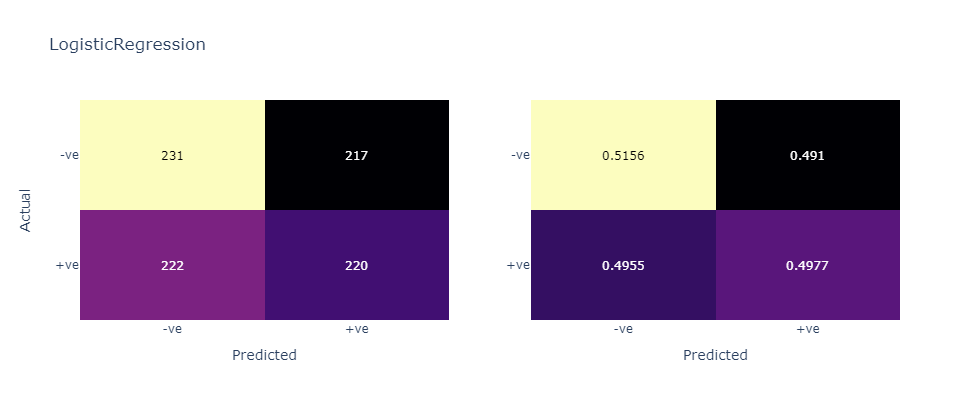

In [255]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_log, title="LogisticRegression"); fig.show()

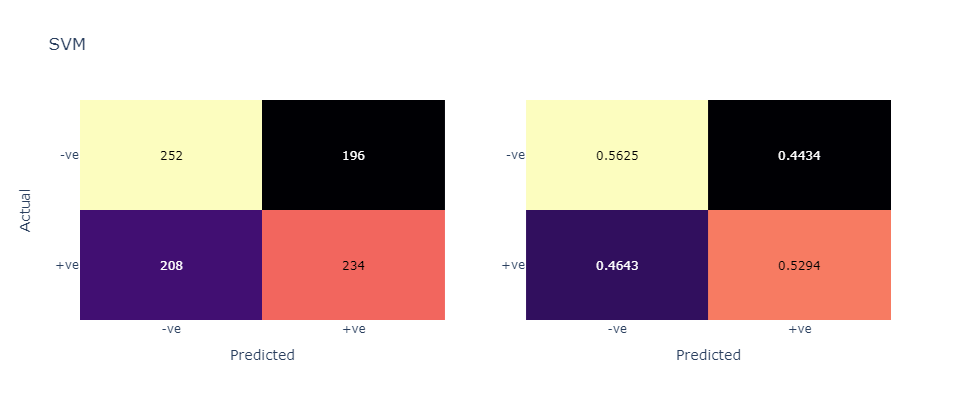

In [256]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_svm, title="SVM"); fig.show()

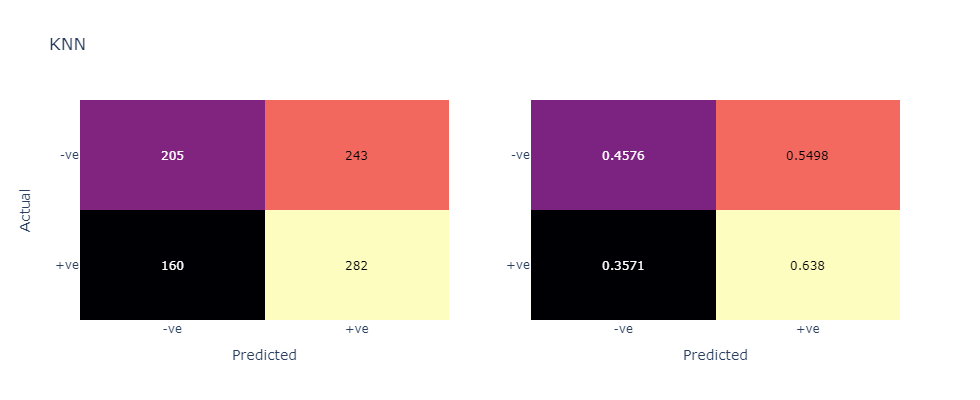

In [257]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_knn, title="KNN"); fig.show()

Testing out if ensemble gives better predictions since it appears

In [261]:
import itertools as it
clfs = {"log":log, "svm":svm, "knn":knn}
combinations = list(it.combinations(["log", "svm", "knn"], 2))
combinations

[('log', 'svm'), ('log', 'knn'), ('svm', 'knn')]

In [262]:
trials = [[("log", clone(log)), ("svm", clone(svm)), ("knn", clone(knn))]] + [[(comb[0],clone(clfs[comb[0]])), (comb[1], clone(clfs[comb[1]]))] for comb in combinations]
trials[0]

[('log',
  LogisticRegression(C=0.5997985829093662, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                     max_iter=10000, multi_class='auto', n_jobs=None,
                     penalty='elasticnet', random_state=42, solver='saga',
                     tol=0.0001, verbose=0, warm_start=False)),
 ('svm',
  SVC(C=1.6656372466228906, break_ties=False, cache_size=200, class_weight=None,
      coef0=0.0, decision_function_shape='ovr', degree=3,
      gamma=0.05415419623675779, kernel='rbf', max_iter=-1, probability=True,
      random_state=42, shrinking=True, tol=0.001, verbose=False)),
 ('knn',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=38, p=2,
                       weights='uniform'))]

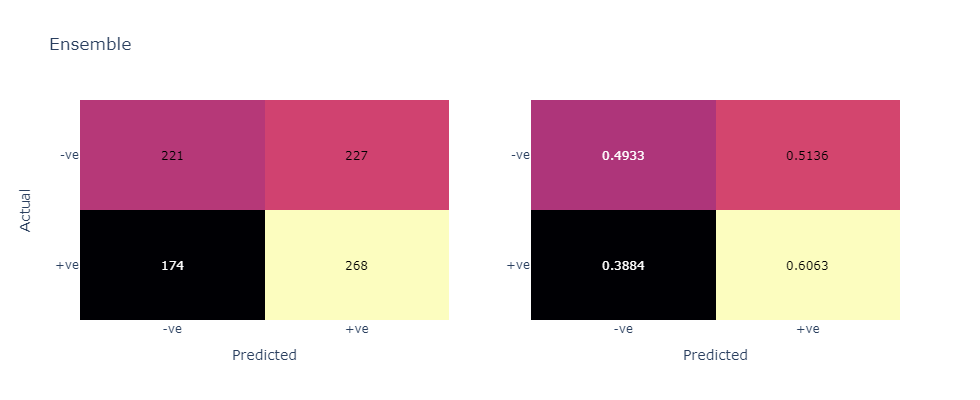

In [260]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

trial_number = 0
voting="hard"

ensemble = VotingClassifier(estimators=trials[trial_number], voting=voting, n_jobs=-1)
conf_mx_ens, y_train_pred_ens = utils.get_confusion_matrix(ensemble, X_train_scaled, y_train.ravel(), cv=5)
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_ens, title="Ensemble"); fig.show()

Strangely enough I found that soft voting gave much lower True Negative's and higher False Positives

## Precision and Recall

+ Precision \
accuracy of +ve **predictions**\
out of TP+FP +ve class **predictions**, TP of them were **actually** +ve class \
$$
Precision = \frac{TP}{TP + FP}
$$
<br><br>
+ Recall \
ratio of **actual** +ve instances that are correctly predicted by classifer. \
out of TP + FN (total of **actual** +ve classes) TP of them were correctly predicted as +ve
$$
Recall = \frac{TP}{TP + FN}
$$

Increasing precision reduces recall and vice versa
+ increasing threshold increases precision (usually) and reduces recall
+ decreasing threshold reduces precision (usually) and increases recall

In [263]:
TN, FP = conf_mx_knn[0, 0], conf_mx_knn[0, 1]
FN, TP = conf_mx_knn[1, 0], conf_mx_knn[1, 1]

headers = ["TP", "TN", "FP", "FN"]
tabular_data = [[TP, TN, FP, FN]]
table = tabulate(tabular_data, headers)
print(table)

  TP    TN    FP    FN
----  ----  ----  ----
 282   205   243   160


In [264]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

**Precision/Accuracy of positive classes (up moves)**

In [265]:
f"{round(TP/(TP+FP), 5)*100} %" # same result from precision_score(y_train.ravel(), y_train_pred_knn)

'53.714 %'

**Recall/Sensitivity of Positive Class (up moves)**

Recall is also know as the Sensitivity or True Positive Rate (TPR). \
This is the ratio of postitive instances that are correctly detected by the classifier

In [266]:
f"{round(TP/(TP+FN), 5)*100} %" # same result from recall_score(y_train.ravel(), y_train_pred_knn)

'63.800999999999995 %'

**True Negative Rate** (TNR) or **specificity**\
ratio of negative instances that are correctly classified as negative (TN)
<br>
$$
TNR = \frac{TN}{TN+FP}
$$
<br><br>

In [267]:
f"{round(TN/(TN+FP), 5)*100} %"

'45.759 %'

**False Positive Rate** (FPR)
<br>
ratio of negative instances that are incorrectly classified as positive (FP)
<br>
$$
FPR = 1 - TNR
$$
<br><br>
$$
FPR = \frac{FP}{TN+FP}
$$

In [268]:
f"{round(FP/(TN+FP), 5)*100} %"

'54.24099999999999 %'

In [269]:
# Across all classifiers
conf_matricies = [conf_mx_log, conf_mx_svm, conf_mx_knn, conf_mx_ens]
headers = ["log", "svm", "knn", "ensemble"]
series_list = []

def get_metricies(conf, name=None):
    TN, FP = conf[0, 0], conf[0, 1]
    FN, TP = conf[1, 0], conf[1, 1]
    
    precision = round(TP / (TP + FP), 5)
    recall = round(TP/ (TP + FN), 5)
    
    tnr = round(TN / (TN + FP), 5)
    
    fpr = round(FP / (TN+FP), 5)
    accuracy = round((TP + TN) / (TP+TN+FP+FN), 5)
    series = pd.Series({"precision":precision, "recall":recall, "TNR": tnr, "FPR":fpr, "accuracy":accuracy}, name=name)
    
    return series

for conf_mx, name in zip(conf_matricies, headers):
    
    series = get_metricies(conf_mx, name=name)
    series_list.append(series)

df_quality_tmp = pd.DataFrame(series_list).T
df_quality_train = df_quality_tmp.drop("ensemble", axis=1).copy()
df_quality_tmp

log      svm      knn  ensemble
precision  0.50343  0.54419  0.53714   0.54141
recall     0.49774  0.52941  0.63801   0.60633
TNR        0.51562  0.56250  0.45759   0.49330
FPR        0.48438  0.43750  0.54241   0.50670
accuracy   0.50674  0.54607  0.54719   0.54944

The various classifiers seem to be able to capure certain classes and not the other.
+ Logistic: poor at identifying down moves, good at capturing up moves
+ SVM: balanced ability to capture up and down moves
+ KNN: poor at predicting up moves, good at capturing down moves.

Extra
+ Ensemble: performs better than all other individual classifiers.

**Get Decision Scores**

In [270]:
y_decision_log = cross_val_predict(log, X_train_scaled, y_train.ravel(), cv=5, method="decision_function")
y_decision_svm = cross_val_predict(svm, X_train_scaled, y_train.ravel(), cv=5, method="decision_function")

**Get Probabilities for Class Labels**

In [271]:
y_proba_log = cross_val_predict(log, X_train_scaled, y_train.ravel(), cv=5, method="predict_proba")
y_proba_svm = cross_val_predict(svm, X_train_scaled, y_train.ravel(), cv=5, method="predict_proba")
y_proba_knn = cross_val_predict(knn, X_train_scaled, y_train.ravel(), cv=5, method="predict_proba")

first column is the probability of y=0 and second column is probability y=1

In [272]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, title=None):
    
    fig = go.Figure()
    
    trace1a = go.Scatter(x=thresholds, y=precisions, name="precision", marker=dict(color="blue"))
    trace1b = go.Scatter(x=thresholds, y=recalls, name="recall", marker=dict(color="red"))
    
    fig.add_trace(trace1a)
    fig.add_trace(trace1b)
    
    fig.update_layout(height=500, width=1000,
                      title=title, showlegend=True
                     )
    
#     tick_kwargs = {
#         'tickmode':'linear', 
#         'tick0':0,
#         'dtick':0.1
#     }

    fig.update_xaxes(title_text="thresholds")
    fig.update_yaxes(title_text="precision/recall", range=[0, 1], dtick=0.1)
    
    fig.show()

With positive class as 1

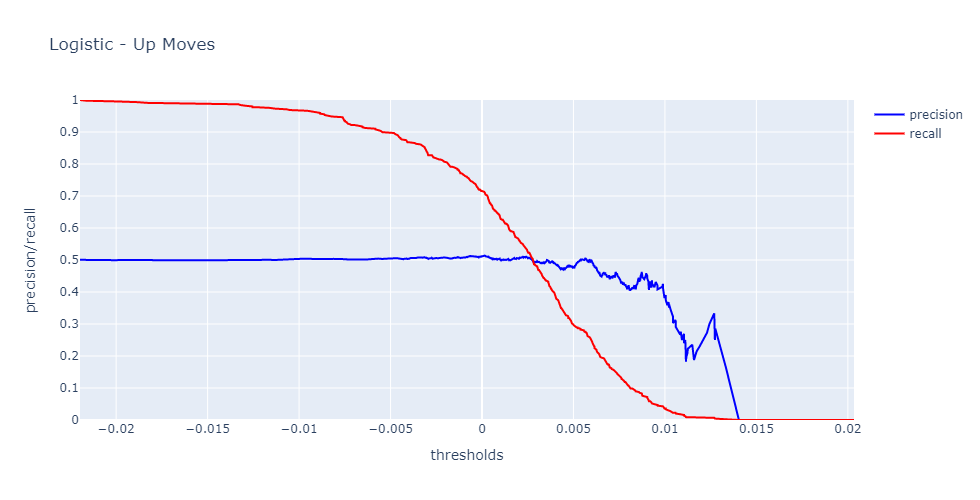

In [992]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_decision_log, pos_label=1)
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, title="Logistic - Up Moves")

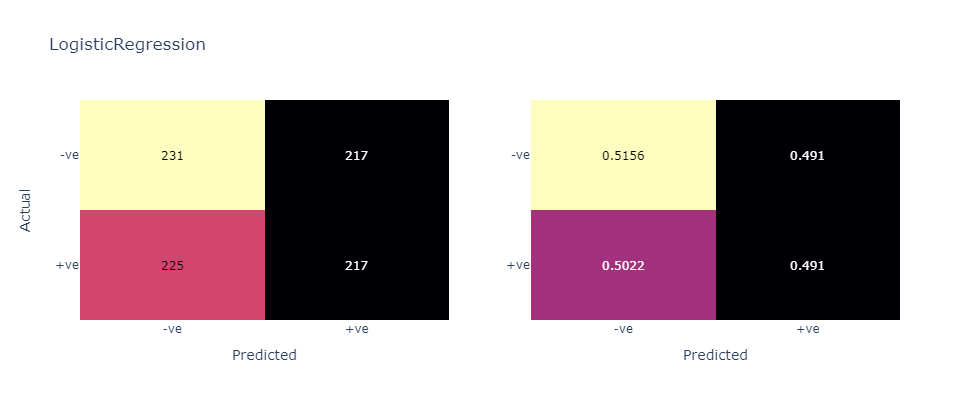

In [275]:
threshold = 0.0027
y_pred_log = (y_decision_log >= threshold).astype("int")

_tmp_conf_mx = confusion_matrix(y_train.ravel(), y_pred_log)

fig = utils.plot_confusion_matrix(conf_mx=_tmp_conf_mx, title="LogisticRegression"); fig.show()

In [276]:
series_list = []

for conf_mx, name in zip([conf_mx_log, _tmp_conf_mx], ["before", "after"]):
    
    series = get_metricies(conf_mx, name=name)
    
    series_list.append(series)

df_quality_log = pd.DataFrame(series_list).T
df_quality_log

before    after
precision  0.50343  0.50000
recall     0.49774  0.49095
TNR        0.51562  0.51562
FPR        0.48438  0.48438
accuracy   0.50674  0.50337

For the logistic classifier we can alter the threshold to increase its ability to capture down moves, \
however this also increases the number of False Negatives (incorrectly predicted up moves as down) \
and reduces the accuracy of the model.

If we had imbalanced classes we could also use bagging to recreate training sets with more balanced classes, \
however we have a roughly equaly split of up and down moves within the dataset here.

## ROC

`roc_curve(...)` expects **scores** from a decision function. However we can also pass in class probabilities. \
In this case a binary classifier will have 2 columns, one for each class. \
We pass in the probabilities for the class that we want the `roc_curve(..)` to treat as the **positive class**

In [277]:
from sklearn.metrics import roc_curve

Is there a way to make a good precision/recall tradeoff?

In [278]:
def plot_roc_curve(fpr, tpr, title=None):
    fig = go.Figure()
    
    trace1 = go.Scatter(x=fpr, y=tpr)
    
    fig.add_trace(trace1)
    
    fig.update_layout(height=500, width=500,
        xaxis=dict(title="FPR(specificity)", range=[0, 1]),
        yaxis=dict(title="TPR(recall)", range=[0, 1]),
        title=title, showlegend=False
    )
    
    fig.show()

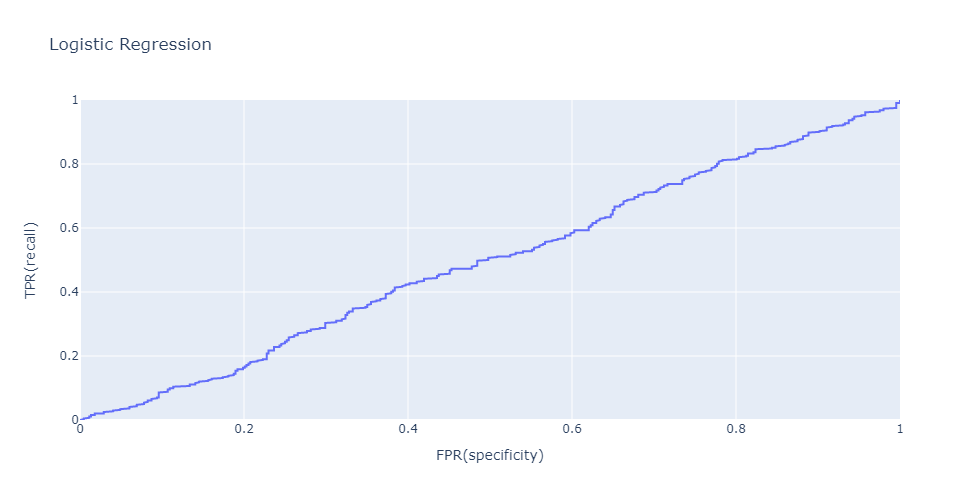

In [279]:
fpr, tpr, thresholds = roc_curve(y_train, y_decision_log, pos_label=1)
plot_roc_curve(fpr, tpr, title="Logistic Regression")

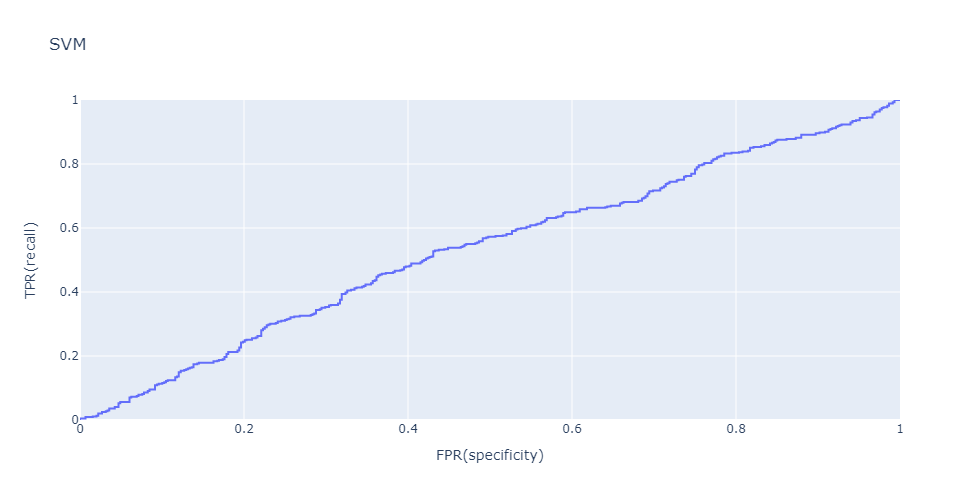

In [280]:
fpr, tpr, thresholds = roc_curve(y_train, y_decision_svm, pos_label=1)
plot_roc_curve(fpr, tpr, title="SVM")

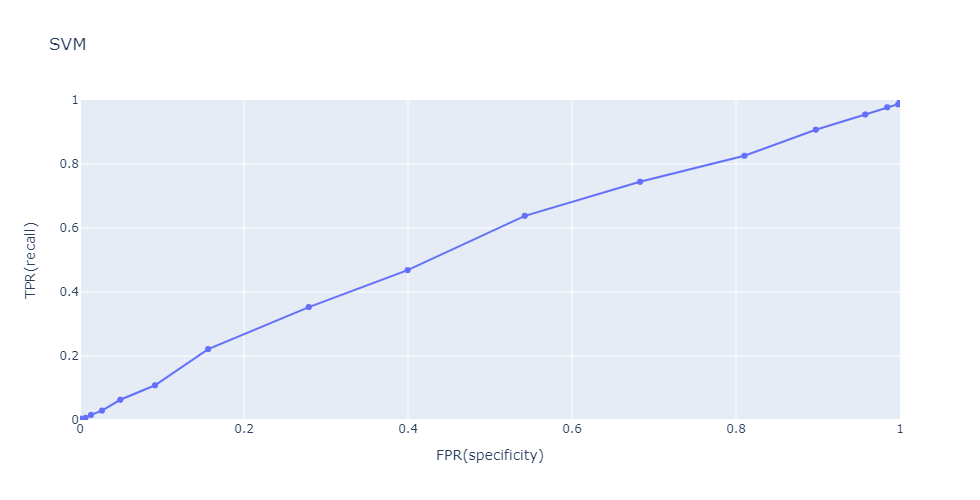

In [281]:
fpr, tpr, thresholds = roc_curve(y_train, y_proba_knn[:, 1], pos_label=1)
plot_roc_curve(fpr, tpr, title="SVM")

ROC AUC \
`roc_auc_score(...)` - returns area under the curve of the fpr plotteed against the tpr

In [282]:
_tmp_series = pd.Series({
    "log":roc_auc_score(y_train, y_decision_log),
    "svm":roc_auc_score(y_train, y_decision_svm),
    "knn":roc_auc_score(y_train, y_proba_knn[:, 1]),
},
    name= "roc_auc_score"
)

df_quality_train = df_quality_train.append(_tmp_series)
df_quality_train.round(4).loc["roc_auc_score"]

log    0.4973
svm    0.5353
knn    0.5494
Name: roc_auc_score, dtype: float64

Logistic: Ability to capture down moves is worse than a dummy classifier.

# Accuracy on test / out of sample

In [283]:
series_list = []

for clf, name in zip([log, svm, knn], ["log", "svm", "knn"]):
    y_test_pred = clf.predict(X_test_scaled)
    
    conf_mx = confusion_matrix(y_test, y_test_pred)
    
    series = get_metricies(conf_mx, name)
    
    series_list.append(series)

df_quality_test = pd.DataFrame(series_list).T

In [284]:
df_quality_test.join(df_quality_train, lsuffix="_test", rsuffix="_train").round(3)

log_test  svm_test  knn_test  log_train  svm_train  knn_train
precision     0.504     0.562     0.568      0.503      0.544      0.537
recall        0.466     0.412     0.511      0.498      0.529      0.638
TNR           0.487     0.641     0.564      0.516      0.562      0.458
FPR           0.513     0.359     0.436      0.484      0.438      0.542
accuracy      0.476     0.520     0.536      0.507      0.546      0.547

% change in metrices from train to test dataset

In [285]:
df_quality_pct = (((df_quality_test - df_quality_train) / df_quality_train)*100).dropna()

In [286]:
df_quality_pct.round(2)

log    svm    knn
FPR        5.87 -17.95 -19.64
TNR       -5.52  13.96  23.28
accuracy  -6.10  -4.74  -1.99
precision  0.14   3.36   5.71
recall    -6.45 -22.14 -19.84

In [287]:
df_quality_pct.mean(axis=1).round(2)

FPR         -10.57
TNR          10.57
accuracy     -4.28
precision     3.07
recall      -16.14
dtype: float64

overall accuracy across all classifiers has reduced by ~4.3%

## Accuracy on second stock

Here we see how well the model will perform on a seconda stock. \
First lets see how correlated the return **signs** (since this is target) for the two stocks are to give an indication of expected performance.

In [288]:
returns_1 = df_work[symbol_list[0]][TARGET_COL]
returns_2 = df_work[symbol_list[1]][TARGET_COL]
returns_1.name = symbol_list[0]
returns_2.name = symbol_list[1]

In [289]:
_tmp_df = pd.DataFrame([returns_1, returns_2]).T
_tmp_df.head()

MNTA  ZTS
date                 
2015-06-19   1.0 -1.0
2015-06-22   1.0  1.0
2015-06-23  -1.0 -1.0
2015-06-24  -1.0  1.0
2015-06-25   1.0 -1.0

In [290]:
_tmp_df.corr()

MNTA       ZTS
MNTA  1.000000  0.267106
ZTS   0.267106  1.000000

They have a low correlation, hence I do not expect this to do very well

**NOTE**: I have made an error here, the scales for the values of the SMA and EWMA between the two stocks is vastly different. \
hence the use of `scalar.transform(stock2)` does not work well and causes errors in the classifiers due to feature values \
significantly outside of the scale that they were trained on. In the future I will need to identify alternative features that do not \
have a scale instrinstic to the dataset if I wish to use a model trained on 1 stock for another stock. \
For now I just made a crude adjustment to fix this but below values are therefore not correct.

In [334]:
X2, Y2 = initial_sample_preparation(df_work[symbol_list[1]])

In [335]:
X2_scaled = scalar.transform(X2)
y2 = Y2.values.ravel()

In [336]:
from sklearn.dummy import DummyClassifier
series_list = []

# Train a Dummy Classifier
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train_scaled, y_train.ravel())

for clf, name in zip([log, svm, knn, dummy], ["log", "svm", "knn", "dummy"]):
    
    y_stock2_pred = clf.predict(X2_scaled)
    
    conf_mx = confusion_matrix(y2, y_stock2_pred)
    
    series = get_metricies(conf_mx, name)
    
    series_list.append(series)

df2_quality_test = pd.DataFrame(series_list).T
df2_quality_test.join(df_quality_train, lsuffix="_Stock2", rsuffix="_Stock1").round(3)

log_Stock2  svm_Stock2  knn_Stock2  dummy  log_Stock1  svm_Stock1  \
precision       0.521       0.557       0.535  0.536       0.503       0.544   
recall          0.523       0.270       0.431  0.488       0.498       0.529   
TNR             0.440       0.750       0.564  0.508       0.516       0.562   
FPR             0.560       0.250       0.436  0.492       0.484       0.438   
accuracy        0.484       0.492       0.492  0.497       0.507       0.546   

           knn_Stock1  
precision       0.537  
recall          0.638  
TNR             0.458  
FPR             0.542  
accuracy        0.547

Models are worse or as good as a dummy classifier on the second stock

# B.3

Logistic Regression

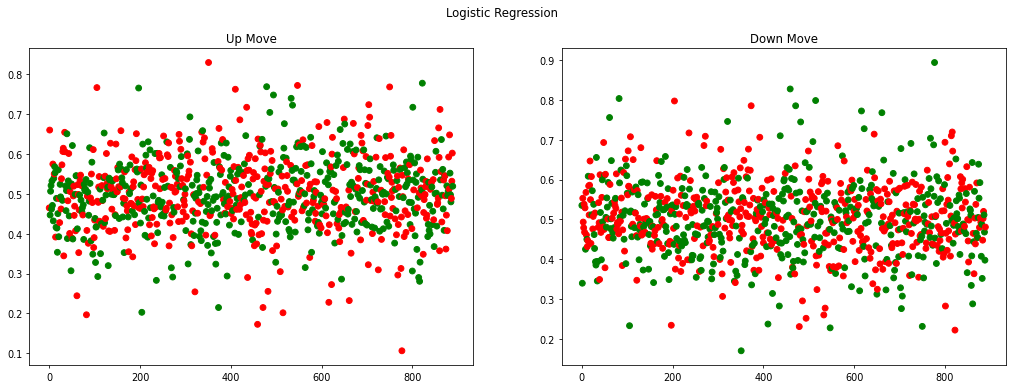

In [294]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=70)
y_pred_up = y_proba_log[:, 1] >= 0.5
y_pred_down = y_proba_log[:, 0] > 0.5

colors = np.where(y_train == y_pred_up, "green", "red").ravel()
axes[0].scatter(x=range(y_pred_up.shape[0]), y=y_proba_log[:, 1], c=colors)
axes[0].set_title("Up Move")

colors = np.where(y_train == y_pred_down, "green", "red").ravel()
axes[1].scatter(x=range(y_pred_up.shape[0]), y=y_proba_log[:, 0], c=colors)
axes[1].set_title("Down Move")

fig.suptitle("Logistic Regression");

SVM

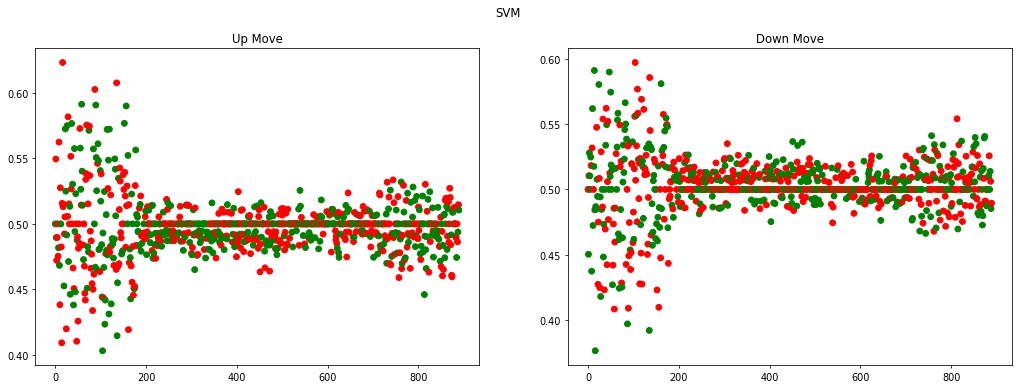

In [295]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=70)
y_pred_up = y_proba_svm[:, 1] >= 0.5
y_pred_down = y_proba_svm[:, 0] > 0.5

colors = np.where(y_train == y_pred_up, "green", "red").ravel()
axes[0].scatter(x=range(y_pred_up.shape[0]), y=y_proba_svm[:, 1], c=colors)
axes[0].set_title("Up Move")

colors = np.where(y_train == y_pred_down, "green", "red").ravel()
axes[1].scatter(x=range(y_pred_up.shape[0]), y=y_proba_svm[:, 0], c=colors)
axes[1].set_title("Down Move")

fig.suptitle("SVM");

## B3 Part II

In [444]:
df_bet = df_work[symbol_list[0]].copy()

with pd.option_context("max_rows", 10, "max_columns", 10):
    display(df_bet)

close  Mkt-RF   SMB   HML   RMW  ...    EWM21D     STD7D  \
date                                         ...                       
2015-06-19  23.78   -0.43  0.52 -0.20  0.07  ...  0.177947  0.046574   
2015-06-22  24.28    0.63  0.09 -0.06 -0.16  ...  0.208668  0.082212   
2015-06-23  24.49    0.12  0.24  0.27 -0.08  ...  0.206445 -0.065269   
2015-06-24  23.52   -0.79 -0.14  0.13  0.18  ...  0.086522 -0.092341   
2015-06-25  22.98   -0.25  0.33 -0.20  0.18  ...  0.023556 -0.077105   
...           ...     ...   ...   ...   ...  ...       ...       ...   
2020-05-12  31.85   -1.44  1.51 -0.43  0.39  ...  0.045173 -0.463793   
2020-05-13  28.98   -1.44  1.51 -0.43  0.39  ... -0.219843  0.769197   
2020-05-14  29.88   -1.44  1.51 -0.43  0.39  ... -0.118039  0.162788   
2020-05-15  31.09   -1.44  1.51 -0.43  0.39  ...  0.002692 -0.106026   
2020-05-18  31.42   -1.44  1.51 -0.43  0.39  ...  0.032447 -0.034043   

              STD14D    STD21D  return_sign  
date                                         
2015-06-19  0.031240  0.016255          1.0  
2015-06-22  0.042984  0.023466          1.0  
2015-06-23  0.046225  0.045402         -1.0  
2015-06-24 -0.070141 -0.085641         -1.0  
2015-06-25 -0.039785 -0.114769          1.0  
...              ...       ...          ...  
2020-05-12 -0.040666 -0.112173         -1.0  
2020-05-13  0.268619  0.034437          1.0  
2020-05-14  0.123702 -0.299760          1.0  
2020-05-15  0.015974 -0.231559          1.0  
2020-05-18  0.003766 -0.048114         -1.0  

[1237 rows x 49 columns]

In [297]:
X_bet, Y_bet = initial_sample_preparation(df_bet)
X_bet_scaled = pd.DataFrame(data=scalar.transform(X_bet), columns=X_bet.columns, index=X_bet.index)
X_bet_scaled.shape[1] == X_train_scaled.shape[1]

True

In [ ]:
X_bet_scaled.info()

### Small Note about SVM probabilities

SVM uses decision function for predicting class labels, training it with `probability=True` only makes it use cross validation for \
generating probabilities and enabling `svm.predict_proba(...)` function.

+ the “argmax” of the scores may not be the argmax of the probabilities

+ in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5.

see [docs][1] for more info on this behaviour.

[1]: https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

### Get Bet DataFrame 

In [409]:
def get_clf_bet_data(clf, X_in, name):
    
    # Get predicted signs
    y_bet_sign_clf = clf.predict(X_in)

    # Get probability of the predicted sign
    m = X_in.shape[0]
    y_bet_proba_clf = clf.predict_proba(X_in)[np.arange(m), y_bet_sign_clf]

    # Create DataFrame for predictions with Datetime index
    y_bet_clf = pd.DataFrame(np.c_[y_bet_sign_clf, y_bet_proba_clf], columns=["pred_sign", "proba"], index=X_in.index)
    
    # replace signs of 0 with -1 for the down moves
    y_bet_clf["pred_sign"].replace(0, -1, inplace=True)
    
    # Create copy of original bet dataframe (has TARGET Column)
    df_copy = df_bet.copy()
    
    # Calculate percentage change (TODO: shift this to earlier in feature engineering section)
    df_copy[f"{RETURN}_pct"] = df_copy[PRICE].pct_change()
    
    # join on Datetime index
    df_copy = df_copy.join(y_bet_clf)
    
    # Select relevant columns
    df_copy = df_copy[[PRICE, RETURN, TARGET_COL, "pred_sign", "proba", f"{RETURN}_pct"]]
    
    # Note that prediction sign and prediction P&L need to be shifted 1 period forward to their "actual" days and hence
    # Their "actual" returns + returns_percent_change
    for col in [TARGET_COL, "pred_sign", "proba"]:
        df_copy.loc[:, col] = df_copy[col].shift(1)
    
    df_copy = df_copy.dropna()
    # Calculate if prediction resulted in a profit or loss (sign of 1 for profit, -1 for loss)
    df_copy["P&L_sign"] = df_copy["pred_sign"] * df_copy[TARGET_COL]
    
    df_copy["allocation"] = ((df_copy["proba"]/df_copy[f"{RETURN}_pct"]) - ((1-df_copy["proba"])/df_copy[f"{RETURN}_pct"])).fillna(0)
    
    df_copy["pred_return"] =  df_copy['pred_sign'] * df_copy[RETURN] * (df_copy["allocation"]/100)
    return df_copy


 Kelly % = W/A – (1 – W)/B

**Get final dataframes for each classifier**

In [410]:
df_bet_svm = get_clf_bet_data(svm, X_bet_scaled, name="svm")
df_bet_knn = get_clf_bet_data(knn, X_bet_scaled, name="knn")
df_bet_log = get_clf_bet_data(log, X_bet_scaled, name="log")

In [411]:
df_bet_knn.head()

close    return  return_sign  pred_sign     proba  return_pct  \
date                                                                        
2015-06-22  24.28  0.020808          1.0       -1.0  0.526316    0.021026   
2015-06-23  24.49  0.008612          1.0       -1.0  0.526316    0.008649   
2015-06-24  23.52 -0.040414         -1.0       -1.0  0.631579   -0.039608   
2015-06-25  22.98 -0.023227         -1.0       -1.0  0.500000   -0.022959   
2015-06-26  23.61  0.027046          1.0        1.0  0.605263    0.027415   

            P&L_sign  allocation  pred_return  
date                                           
2015-06-22      -1.0    2.503158    -0.000521  
2015-06-23      -1.0    6.085213    -0.000524  
2015-06-24       1.0   -6.644059    -0.002685  
2015-06-25       1.0    0.000000     0.000000  
2015-06-26       1.0    7.679198     0.002077

Quick Check: Below cell should return a value of 1 if rows are shifted correctly

In [412]:
accuracy_score(Y_bet.shift(1).dropna().values.ravel(), df_bet_svm[TARGET_COL].replace(-1, 0))

1.0

In [413]:
for df in [df_bet_log, df_bet_svm, df_bet_knn]:
    print(accuracy_score(Y_bet.shift(1).dropna().values.ravel(), df["pred_sign"].replace(-1, 0)))

0.5509708737864077
0.8025889967637541
0.563915857605178


I have no idea why, but these are not the same scores as from training and testing. \
Will look into this later.

In [419]:
tmp = df_bet_svm
tmp.head(3)

close    return  return_sign  pred_sign     proba  return_pct  \
date                                                                        
2015-06-22  24.28  0.020808          1.0        1.0  0.500000    0.021026   
2015-06-23  24.49  0.008612          1.0        1.0  0.538318    0.008649   
2015-06-24  23.52 -0.040414         -1.0       -1.0  0.580328   -0.039608   

            P&L_sign  allocation  pred_return  
date                                           
2015-06-22       1.0    0.000000     0.000000  
2015-06-23       1.0    8.860479     0.000763  
2015-06-24       1.0   -4.056125    -0.001639

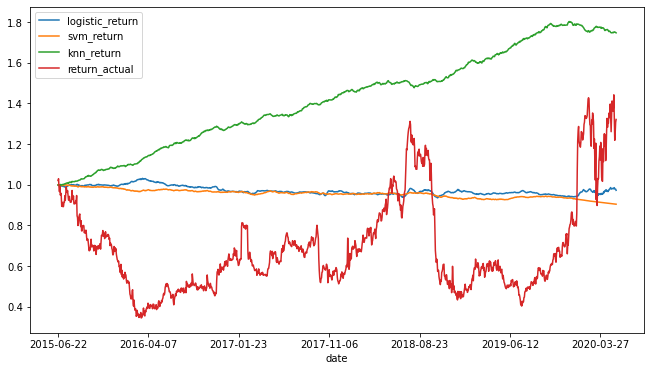

In [420]:
df_compiled = pd.DataFrame()
df_compiled["logistic_return"] = df_bet_log["pred_return"]
df_compiled["svm_return"] = df_bet_svm["pred_return"]
df_compiled["knn_return"] = df_bet_knn["pred_return"]

df_compiled[f"{RETURN}_actual"] = df_bet_log[RETURN]

df_compiled[["logistic_return", "svm_return", "knn_return", f"{RETURN}_actual"]].cumsum().apply(np.exp).plot(figsize=(11, 6))